In [10]:
import math
import os
import random
import torch
from collections import Counter
from d2l import torch as d2l

In [4]:
#读取数据集
d2l.DATA_HUB['ptb']=(d2l.DATA_URL+'ptb.zip',
                '319d85e578af0cdc590547f26231e4e31cdf1e42')
#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir=d2l.download_extract('ptb')
    #Read the training set
    with open(os.path.join(data_dir,'ptb.train.txt')) as f:
        raw_text=f.read()
    return [line.split() for line in raw_text.split('\n')]

In [5]:
sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

In [6]:
#为语料库构建了一个词表，其中出现次数少于10次的任何单词都将由“<unk>”词元替换。请注意，原始数据集还包含表示稀有（未知）单词的“<unk>”词元。
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

#### 下采样
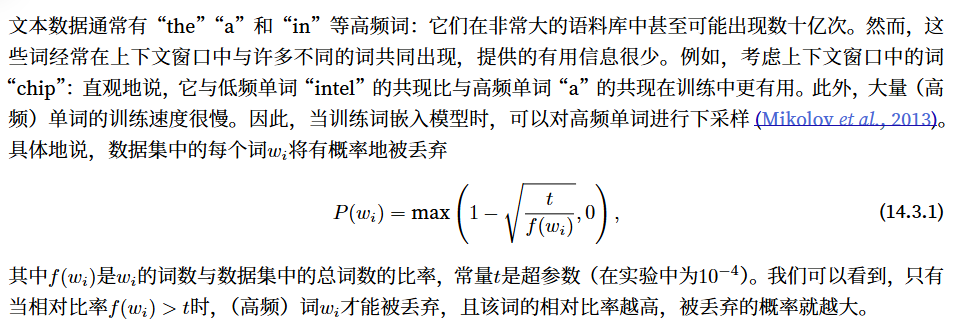

In [11]:
def count_corpus(tokens):
    if len(tokens)==0 or isinstance(tokens[0],list):
        #展平为一维列表
        tokens=[token for line in tokens for token in line]
    return Counter(tokens)
def subsample(sentences,vocab):
    """下采样高频词"""
    #排除未知元'<unk>'
    sentences=[[token for token in line if vocab[token]!=vocab.unk] for line in sentences]
    counter=count_corpus(sentences)
    num_tokens=sum(counter.values())
    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))
    return ([[token for token in line if keep(token)] for line in sentences],counter)
subsampled,counter=subsample(sentences,vocab)

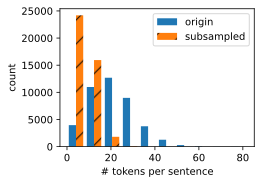

In [12]:
#下采样通过删除高频词来显著缩短句子，这将使训练加速。
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled);

In [13]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')
compare_counts('the')

'"the"的数量：之前=50770, 之后=2048'

In [14]:
#相比之下低频词'join'则被完全保留
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

In [15]:
#在下采样之后，我们将词元映射到它们在语料库中的索引。
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [4127, 3228, 4060], [993, 3922, 1922, 4743]]

#### 中心词和上下文词的提取
下面的get_centers_and_contexts函 数 从corpus中 提 取 所 有 中 心 词 及 其 上 下文词。它随机采样1到max_window_size之间的整数作为上下文窗口。对于任一中心词，与其距离不超过采样上下文窗口大小的词为其上下文词。

In [ ]:
def get_centers_and_contexts(coorpus,max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers,contexts=[],[]
    for line in corpus:
        #要形成“中心词-上下文词”对，每个句子至少需要有2个词